#**0. Clone repository**

In [ ]:
!git clone https://github.com/Thuan-ML/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates.git


Cloning into 'ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 93 (delta 19), reused 12 (delta 12), pack-reused 63 (from 1)
Receiving objects: 100% (93/93), 13.59 MiB | 6.54 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [ ]:
!pip install catboost --quiet
!pip uninstall -y xgboostlss
!pip install xgboostlss --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 11.7 MB/s eta 0:00:00


#**1. Load dataset**

In [ ]:
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from xgboostlss.model import XGBoostLSS
from xgboostlss.distributions.Gaussian import Gaussian





In [ ]:
url = "https://raw.githubusercontent.com/Thuan-ML/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/main/data/input/tax_avoidance.dta"
df = pd.read_stata(url)

#**2. Panel Preparation**

In [ ]:
df = df.sort_values(["firma_id", "rok"])

df["etr_next"] = df.groupby("firma_id")["etr"].shift(-1)


df = df.dropna(subset=["etr_next"])

min_year = df["rok"].min()
max_year = df["rok"].max()


/tmp/ipython-input-693156448.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["etr_next"] = df.groupby("firma_id")["etr"].shift(-1)


In [ ]:

df = df.apply(pd.to_numeric, errors='coerce')


#**3. Remove non-feature columns**

In [ ]:
drop_cols = ["index", "Ticker", "Nazwa2", "sektor", "gielda"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])


#**4. Remove object columns**

In [ ]:
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
df = df.drop(columns=obj_cols)

# **5. Convert categorical columns to integer codes**

In [ ]:

features = [c for c in df.columns if c not in ["etr_next", "etr", "firma_id", "rok"]]

cat_cols = df[features].select_dtypes(include='category').columns

for col in cat_cols:
    df[col] = df[col].cat.codes


#**6. Handle Missing Values**




In [ ]:
df[features] = df[features].fillna(df[features].median())


df_train = df[df["rok"] < max_year].copy()
df_test  = df[df["rok"] == max_year].copy()

df_train = df_train.fillna(df_train.median())
df_test  = df_test.fillna(df_test.median())

cols_to_drop = ["firm_id", "firma_id", "industry", "industry1"]
df_train = df_train.drop(columns=[c for c in cols_to_drop if c in df_train.columns])
df_test  = df_test.drop(columns=[c for c in cols_to_drop if c in df_test.columns])

df_train = df_train.fillna(df_train.median())
df_test  = df_test.fillna(df_test.median())

df_train.head(), df_test.head()


(    rok          ta     txt          pi       str  xrd          ni  ppent  \
 0  2005  110.718002  10.616   25.056000  0.295544  0.0   14.440000  1.801   
 1  2006  250.901993  10.866   28.056999  0.295544  0.0   17.191000  2.005   
 2  2007  385.980988   3.377   27.707001  0.295544  0.0   24.330000  1.934   
 3  2008  182.259003  11.702 -172.373001  0.295544  0.0 -184.074997  1.723   
 4  2009  305.266998   9.687  110.886002  0.294400  0.0  101.123001  1.274   
 
       intant        dlc  ...  industry17  industry18  industry19  industry20  \
 0  39.013000   0.039000  ...         0.0         0.0         0.0         0.0   
 1  38.647999  85.113998  ...         0.0         0.0         0.0         0.0   
 2  85.675003  74.521004  ...         0.0         0.0         0.0         0.0   
 3  82.311996  75.880997  ...         0.0         0.0         0.0         0.0   
 4  81.250000  59.592999  ...         0.0         0.0         0.0         0.0   
 
       diff1     diff2     diff3  _est_ran

In [ ]:
df_train.isna().sum()[df_train.isna().sum() > 0]


,0


#**7. Compute year range**

In [ ]:
min_year = df["rok"].min()
max_year = df["rok"].max()


#**8. Validation years**

In [ ]:
validation_years = list(range(min_year + 1, max_year + 1))

#**9. Feature Ranking & Pick Feature Groups (top 20 / 30 / 50)**

In [ ]:
df_train.select_dtypes(include=['object']).columns


Index([], dtype='object')

In [ ]:
X_full = df_train.drop(columns=["etr_next"])
y_full = df_train["etr_next"]

baseline_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_full, y_full)

perm = permutation_importance(
    baseline_model,
    X_full,
    y_full,
    n_repeats=15,
    random_state=42,
    n_jobs=-1
)

ranking_df = pd.DataFrame({
    "feature": X_full.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

ranking_df.reset_index(drop=True, inplace=True)

ranking_df.head(20)


,feature,importance
0,etr,0.571373
1,country1,0.042571
2,diff,0.038056
3,lev,0.033796
4,roa,0.033143
5,txt,0.033024
6,revenue,0.032043
7,diff3,0.027224
8,sale,0.026679
9,ni,0.025635


In [ ]:

top20 = ranking_df.head(20)["feature"].tolist()
top30 = ranking_df.head(30)["feature"].tolist()
top50 = ranking_df.head(50)["feature"].tolist()

feature_sets = {
    "top20": top20,
    "top30": top30,
    "top50": top50
}

feature_sets


{'top20': ['etr',
  'country1',
  'diff',
  'lev',
  'roa',
  'txt',
  'revenue',
  'diff3',
  'sale',
  'ni',
  'str',
  'diff1',
  'diff2',
  'intant',
  'ppe',
  'dlc',
  'intan',
  'pi',
  'cfc',
  'dltt'],
 'top30': ['etr',
  'country1',
  'diff',
  'lev',
  'roa',
  'txt',
  'revenue',
  'diff3',
  'sale',
  'ni',
  'str',
  'diff1',
  'diff2',
  'intant',
  'ppe',
  'dlc',
  'intan',
  'pi',
  'cfc',
  'dltt',
  'cce',
  'cash_holdings',
  'capex1',
  'capex',
  'roa1',
  'rd',
  'xrd',
  'capex2',
  'ppent',
  'rok'],
 'top50': ['etr',
  'country1',
  'diff',
  'lev',
  'roa',
  'txt',
  'revenue',
  'diff3',
  'sale',
  'ni',
  'str',
  'diff1',
  'diff2',
  'intant',
  'ppe',
  'dlc',
  'intan',
  'pi',
  'cfc',
  'dltt',
  'cce',
  'cash_holdings',
  'capex1',
  'capex',
  'roa1',
  'rd',
  'xrd',
  'capex2',
  'ppent',
  'rok',
  'ta',
  'capex2_scaled',
  'rok2008',
  'adv',
  'industry17',
  'adv_expenditure',
  'rok2010',
  'rok2009',
  'industry20',
  'industry16',
  'i

#**10. Hyperparameter Tuning (AdaBoost)**

In [ ]:
ada = AdaBoostRegressor()

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(
    ada,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1
)

# USE df_train ONLY
X_train_full = df_train.drop(columns=["etr_next"])
y_train_full = df_train["etr_next"]

grid_search.fit(X_train_full, y_train_full)

grid_search.best_params_


{'learning_rate': 0.01, 'n_estimators': 50}

#**11. AdaBoostRegressor**

##**Train AdaBoost Year-by-Year**

---



In [ ]:
all_results = {}

for set_name, feat_list in feature_sets.items():

    results = []

    for year in validation_years:

        train_df = df[df["rok"] < year]
        test_df  = df[df["rok"] == year]

        X_train = train_df[feat_list]
        y_train = train_df["etr_next"]

        X_test  = test_df[feat_list]
        y_test  = test_df["etr_next"]

        model = AdaBoostRegressor()
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        rmse = ((preds - y_test)**2).mean()**0.5

        results.append({"year": year, "rmse": rmse})

    all_results[set_name] = results


In [ ]:
all_results

{'top20': [{'year': 2006, 'rmse': np.float64(0.1382278954175041)},
  {'year': 2007, 'rmse': np.float64(0.15781688770636992)},
  {'year': 2008, 'rmse': np.float64(0.18691733605700991)},
  {'year': 2009, 'rmse': np.float64(0.14937645492870408)},
  {'year': 2010, 'rmse': np.float64(0.1578206908843422)},
  {'year': 2011, 'rmse': np.float64(0.16873272395318206)},
  {'year': 2012, 'rmse': np.float64(0.1618378116817818)},
  {'year': 2013, 'rmse': np.float64(0.1574410054937553)},
  {'year': 2014, 'rmse': np.float64(0.18192026557461063)},
  {'year': 2015, 'rmse': np.float64(0.1769741573362093)},
  {'year': 2016, 'rmse': np.float64(0.11243968632616805)}],
 'top30': [{'year': 2006, 'rmse': np.float64(0.1381008966030318)},
  {'year': 2007, 'rmse': np.float64(0.15344009744860013)},
  {'year': 2008, 'rmse': np.float64(0.19659563974796604)},
  {'year': 2009, 'rmse': np.float64(0.15094569649832695)},
  {'year': 2010, 'rmse': np.float64(0.14996878958286594)},
  {'year': 2011, 'rmse': np.float64(0.16851

##**Average RMSE per Feature Set**

In [ ]:
avg_rmse = {}

for set_name, results in all_results.items():
    # extract RMSE values
    rmse_values = [r["rmse"] for r in results]
    avg_rmse[set_name] = np.mean(rmse_values)

avg_rmse

{'top20': np.float64(0.15904590139633068),
 'top30': np.float64(0.15316987172882104),
 'top50': np.float64(0.16071779461029895)}

##**Pick the Best Feature Group**

In [ ]:
champion_set = min(avg_rmse, key=avg_rmse.get)
champion_set

'top30'

##**The final AdaBoost model**

In [ ]:
champion_features = feature_sets[champion_set]

model_ada_champion = AdaBoostRegressor()
model_ada_champion.fit(df[champion_features], df["etr_next"])


AdaBoostRegressor()

In [ ]:

joblib.dump(
    model_ada_champion,
    "/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/ada_champion.pkl"
)

['/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/ada_champion.pkl']

#**12. GradientBoostingRegressor GBM**

##**Train GBM Year-by-Year**

In [ ]:
gbm_results = {}

for set_name, feat_list in feature_sets.items():

    results = []

    for year in validation_years:

        train_df = df[df["rok"] < year]
        test_df  = df[df["rok"] == year]

        X_train = train_df[feat_list]
        y_train = train_df["etr_next"]

        X_test = test_df[feat_list]
        y_test = test_df["etr_next"]

        model = GradientBoostingRegressor()
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        rmse = ((preds - y_test)**2).mean()**0.5

        results.append({"year": year, "rmse": rmse})

    gbm_results[set_name] = results


##**Average RMSE per Feature Set**

In [ ]:
gbm_avg_rmse = {}

for set_name, results in gbm_results.items():
    rmse_values = [r["rmse"] for r in results]
    gbm_avg_rmse[set_name] = np.mean(rmse_values)

gbm_avg_rmse


{'top20': np.float64(0.14354007005837224),
 'top30': np.float64(0.14316084516113411),
 'top50': np.float64(0.14349360627300353)}

##**Pick the Best Feature Group**

In [ ]:
gbm_champion_set = min(gbm_avg_rmse, key=gbm_avg_rmse.get)
gbm_champion_set

'top30'

##**The final GBM model**

In [ ]:
gbm_champion_features = feature_sets[gbm_champion_set]

final_gbm_model = GradientBoostingRegressor()
final_gbm_model.fit(df[gbm_champion_features], df["etr_next"])


GradientBoostingRegressor()

In [ ]:
joblib.dump(
    final_gbm_model,
    "/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/gbm_champion.pkl"
)

['/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/gbm_champion.pkl']

#**13. GBM Histogram - HistGradientBoostingRegressor**

##**Train HGBM Year-by-Year**

In [ ]:
hgbm_results = {}

for set_name, feat_list in feature_sets.items():

    results = []

    for year in validation_years:

        train_df = df[df["rok"] < year]
        test_df  = df[df["rok"] == year]

        X_train = train_df[feat_list]
        y_train = train_df["etr_next"]

        X_test = test_df[feat_list]
        y_test = test_df["etr_next"]

        model = HistGradientBoostingRegressor()
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        rmse = ((preds - y_test)**2).mean()**0.5

        results.append({"year": year, "rmse": rmse})

    hgbm_results[set_name] = results


##**Average RMSE per Feature Set**

In [ ]:
hgbm_avg_rmse = {}

for set_name, results in hgbm_results.items():
    rmse_values = [r["rmse"] for r in results]
    hgbm_avg_rmse[set_name] = np.mean(rmse_values)

hgbm_avg_rmse


{'top20': np.float64(0.1457399246099626),
 'top30': np.float64(0.14596347664778492),
 'top50': np.float64(0.14575740845800123)}

##**Pick the Best Feature Group**

In [ ]:
hgbm_champion_set = min(hgbm_avg_rmse, key=hgbm_avg_rmse.get)
hgbm_champion_set

'top20'

##**The final HGBM model**

In [ ]:
hgbm_champion_features = feature_sets[hgbm_champion_set]

final_hgbm_model = HistGradientBoostingRegressor()
final_hgbm_model.fit(df[hgbm_champion_features], df["etr_next"])

HistGradientBoostingRegressor()

In [ ]:
joblib.dump(
    final_hgbm_model,
    "/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/hgbm_champion.pkl"
)


['/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/hgbm_champion.pkl']

#**14. XGBoost**

##**Train XGBoost Year-by-Year**

In [ ]:
xgb_results = {}

for set_name, feat_list in feature_sets.items():

    results = []

    for year in validation_years:

        train_df = df[df["rok"] < year]
        test_df  = df[df["rok"] == year]

        X_train = train_df[feat_list]
        y_train = train_df["etr_next"]

        X_test = test_df[feat_list]
        y_test = test_df["etr_next"]

        model = XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100
        )
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        rmse = ((preds - y_test)**2).mean()**0.5

        results.append({"year": year, "rmse": rmse})

    xgb_results[set_name] = results


##**Average RMSE per Feature Set**

In [ ]:
xgb_avg_rmse = {}

for set_name, results in xgb_results.items():
    rmse_values = [r["rmse"] for r in results]
    xgb_avg_rmse[set_name] = np.mean(rmse_values)

xgb_avg_rmse


{'top20': np.float64(0.15209118944644084),
 'top30': np.float64(0.1557369607810276),
 'top50': np.float64(0.15254144424439625)}

##**Pick the Best Feature Group**

In [ ]:
xgb_champion_set = min(xgb_avg_rmse, key=xgb_avg_rmse.get)
xgb_champion_set

'top20'

##**The final XGBoost model**

In [ ]:
xgb_champion_features = feature_sets[xgb_champion_set]

final_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100
)
final_xgb_model.fit(df[xgb_champion_features], df["etr_next"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
joblib.dump(
    final_xgb_model,
    "/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/xgb_champion.pkl"
)


['/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/xgb_champion.pkl']

#**15. LightGBM**

##**Train LightGBM Year-by-Year**

In [ ]:
lgbm_results = {}

for set_name, feat_list in feature_sets.items():

    results = []

    for year in validation_years:

        train_df = df[df["rok"] < year]
        test_df  = df[df["rok"] == year]

        X_train = train_df[feat_list]
        y_train = train_df["etr_next"]

        X_test = test_df[feat_list]
        y_test = test_df["etr_next"]

        model = LGBMRegressor()
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        rmse = ((preds - y_test)**2).mean()**0.5

        results.append({"year": year, "rmse": rmse})

    lgbm_results[set_name] = results


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 363, number of used features: 20
[LightGBM] [Info] Start training from score 0.223732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

##**Average RMSE per Feature Set**

In [ ]:
lgbm_avg_rmse = {}

for set_name, results in lgbm_results.items():
    rmse_values = [r["rmse"] for r in results]
    lgbm_avg_rmse[set_name] = np.mean(rmse_values)

lgbm_avg_rmse

{'top20': np.float64(0.14540720408599658),
 'top30': np.float64(0.14567204319049926),
 'top50': np.float64(0.14574622444520843)}

##**Pick the Best Feature Group**

In [ ]:
lgbm_champion_set = min(lgbm_avg_rmse, key=lgbm_avg_rmse.get)
lgbm_champion_set

'top20'

##**The final LightGBM model**

In [ ]:
lgbm_champion_features = feature_sets[lgbm_champion_set]

final_lgbm_model = LGBMRegressor()
final_lgbm_model.fit(df[lgbm_champion_features], df["etr_next"])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4496
[LightGBM] [Info] Number of data points in the train set: 4356, number of used features: 20
[LightGBM] [Info] Start training from score 0.214587


LGBMRegressor()

In [ ]:
joblib.dump(
    final_lgbm_model,
    "/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/lgbm_champion.pkl"
)


['/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/lgbm_champion.pkl']

#**16. CatBoost**

##**Train CatBoost Year-by-Year**

In [ ]:
catboost_results = {}

for set_name, feat_list in feature_sets.items():

    results = []

    for year in validation_years:

        train_df = df[df["rok"] < year]
        test_df  = df[df["rok"] == year]

        X_train = train_df[feat_list]
        y_train = train_df["etr_next"]

        X_test = test_df[feat_list]
        y_test = test_df["etr_next"]

        model = CatBoostRegressor(
            verbose=0
        )
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        rmse = ((preds - y_test)**2).mean()**0.5

        results.append({"year": year, "rmse": rmse})

    catboost_results[set_name] = results


##**Average RMSE per Feature Set**

In [ ]:
catboost_avg_rmse = {}

for set_name, results in catboost_results.items():
    rmse_values = [r["rmse"] for r in results]
    catboost_avg_rmse[set_name] = np.mean(rmse_values)

catboost_avg_rmse


{'top20': np.float64(0.1438736632865899),
 'top30': np.float64(0.14476874958382682),
 'top50': np.float64(0.14335362467895005)}

##**Pick the Best Feature Group**

In [ ]:
catboost_champion_set = min(catboost_avg_rmse, key=catboost_avg_rmse.get)
catboost_champion_set

'top50'

##**The final CatBoost model**

In [ ]:
catboost_champion_features = feature_sets[catboost_champion_set]

final_catboost_model = CatBoostRegressor(verbose=0)
final_catboost_model.fit(df[catboost_champion_features], df["etr_next"])

In [ ]:
joblib.dump(
    final_catboost_model,
    "/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/catboost_champion.pkl"
)

['/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/catboost_champion.pkl']

#**17. XGBoostLSS**

##**Train XGBoostLSS Year-by-Year**

In [ ]:
url = "https://raw.githubusercontent.com/Thuan-ML/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/main/data/input/tax_avoidance.dta"
df = pd.read_stata(url)


df = df.sort_values(["firma_id", "rok"])

df["etr_next"] = df.groupby("firma_id")["etr"].shift(-1)
df = df.dropna(subset=["etr_next"])

df.columns



/tmp/ipython-input-3750308260.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["etr_next"] = df.groupby("firma_id")["etr"].shift(-1)


Index(['index', 'Ticker', 'Nazwa2', 'sektor', 'rok', 'gielda', 'ta', 'txt',
       'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex',
       'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd',
       'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc',
       'dta', 'capex2_scaled', 'firm_id', 'firma_id', 'rok2005', 'rok2006',
       'rok2007', 'rok2008', 'rok2009', 'rok2010', 'rok2011', 'rok2012',
       'rok2013', 'rok2014', 'rok2015', 'rok2016', 'rok2017', 'industry',
       'industry1', 'capex1', 'roa1', 'country1', 'country2', 'country3',
       'country4', 'country5', 'industry11', 'industry12', 'industry13',
       'industry14', 'industry15', 'industry16', 'industry17', 'industry18',
       'industry19', 'industry20', 'diff1', 'diff2', 'diff3', '_est_random',
       '_est_fixed', 'etr_next'],
      dtype='object')

In [ ]:
xgblss_results = {}

for set_name, feat_list in feature_sets.items():

    results = []
    dist = Gaussian()

    for year in validation_years:

        train_df = df[df["rok"] < year]
        test_df  = df[df["rok"] == year]

        X_train = train_df[feat_list].values
        y_train = train_df["etr_next"].values

        X_test  = test_df[feat_list].values
        y_test  = test_df["etr_next"].values

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest  = xgb.DMatrix(X_test,  label=y_test)

        params = {
            "eta": 0.05,
            "max_depth": 3,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
        }

        model = XGBoostLSS(dist)
        model.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=300
        )

        pred_dist = model.predict(dtest, pred_type="parameters")

        if "mu" in pred_dist.columns:
            preds = pred_dist["mu"].values
        elif "loc" in pred_dist.columns:
            preds = pred_dist["loc"].values
        else:
            raise ValueError("Cannot identify distribution mean in prediction output.")

        rmse = np.sqrt(np.mean((preds - y_test) ** 2))
        results.append({"year": year, "rmse": rmse})

    xgblss_results[set_name] = results


/usr/local/lib/python3.12/dist-packages/xgboostlss/utils.py:20: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  nan=float(torch.nanmean(predt)),
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(
/usr/local/lib/python3.1

##**Average RMSE per Feature Set**

In [ ]:
xgblss_avg_rmse = {}

for set_name, results in xgblss_results.items():
    rmse_values = [r["rmse"] for r in results]
    xgblss_avg_rmse[set_name] = np.mean(rmse_values)

xgblss_avg_rmse



{'top20': np.float64(0.1417316308914003),
 'top30': np.float64(0.14168962002341426),
 'top50': np.float64(0.1411797580680556)}

##**Pick the Best Feature Group**

In [ ]:
xgblss_champion_set = min(xgblss_avg_rmse, key=xgblss_avg_rmse.get)
xgblss_champion_set


'top50'

##**The final XGBoostLSS model**

In [ ]:
champion_features = feature_sets[xgblss_champion_set]
dist = Gaussian()

X_full = df[champion_features].values
y_full = df["etr_next"].values

dtrain_full = xgb.DMatrix(X_full, label=y_full)

params = {
    "eta": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

final_xgblss_model = XGBoostLSS(dist)
final_xgblss_model.train(
    params=params,
    dtrain=dtrain_full,
    num_boost_round=300
)

final_pred = final_xgblss_model.predict(dtrain_full, pred_type="parameters")
final_pred.head()


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


,loc,scale
0,0.310666,0.056422
1,0.240770,0.085621
2,0.167871,0.143821
3,0.110900,0.053209
4,0.195250,0.136921


In [ ]:
joblib.dump(
    final_xgblss_model,
    "/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/xgblss_champion.pkl"
)

['/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/xgblss_champion.pkl']

#**18. Comparison**

##**Load all models**

In [ ]:
model_dir = "/content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/"

models = {
    "AdaBoost": joblib.load(model_dir + "ada_champion.pkl"),
    "GBM": joblib.load(model_dir + "gbm_champion.pkl"),
    "HGBM": joblib.load(model_dir + "hgbm_champion.pkl"),
    "XGBoost": joblib.load(model_dir + "xgb_champion.pkl"),
    "LightGBM": joblib.load(model_dir + "lgbm_champion.pkl"),
    "CatBoost": joblib.load(model_dir + "catboost_champion.pkl"),
    "XGBoostLSS": joblib.load(model_dir + "xgblss_champion.pkl"),
}

models


{'AdaBoost': AdaBoostRegressor(),
 'GBM': GradientBoostingRegressor(),
 'HGBM': HistGradientBoostingRegressor(),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...),
 'LightGBM': LGBMRegressor(),
 'CatBoost': <catboost.core.CatBoostRegressor at 0x7c3f00f6fb60>,
 'XGBoostLSS': <xgb

##**Evaluate All Models on Test Set**

In [ ]:
test_df = df[df["rok"] == df["rok"].max()]

In [ ]:

models_for_eval = {k: v for k, v in models.items() if k != "CatBoost"}

test_numeric = test_df.select_dtypes(include=[np.number]).copy()
test_numeric = test_numeric.fillna(test_numeric.median())

y_test = test_numeric["etr_next"].values
test_numeric = test_numeric.drop(columns=["etr_next"])

rmse_results = {}

for name, model in models_for_eval.items():

    try:
        n_feats = model.n_features_in_
    except:
        try:
            n_feats = len(model.feature_names_)
        except:
            n_feats = model.booster.num_features()

    X_test_mat = test_numeric.iloc[:, :n_feats].values

    if name == "XGBoostLSS":
        dtest = xgb.DMatrix(X_test_mat)
        pred_dist = model.predict(dtest, pred_type="parameters")
        preds = pred_dist.iloc[:, 0].values
    else:
        preds = model.predict(X_test_mat)

    rmse_results[name] = float(np.sqrt(np.mean((preds - y_test)**2)))

rmse_results


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'AdaBoost': 0.16166948367608763,
 'GBM': 0.36302203833827257,
 'HGBM': 0.10824167504594834,
 'XGBoost': 0.4416356280127333,
 'LightGBM': 0.09136167970887701,
 'XGBoostLSS': 0.5629962921002809}

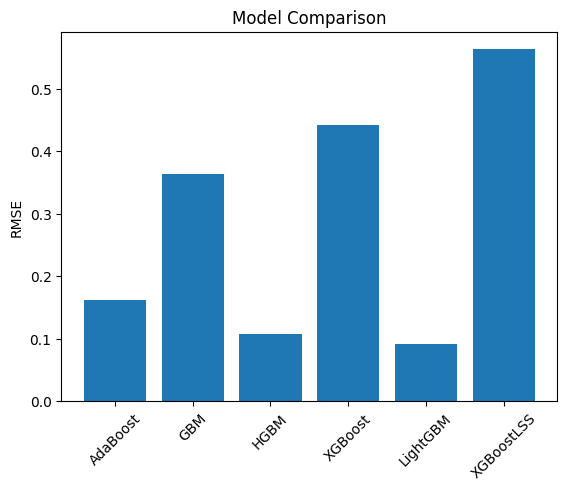

In [ ]:

plt.bar(rmse_results.keys(), rmse_results.values())
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Model Comparison")
plt.show()


##**Conclusion**

LightGBM is the best model — it predicts ETR most accurately.  

HGBM is second best.  

Both are better than AdaBoost, GBM, XGBoost, and XGBoostLSS.





In [ ]:
!mkdir -p /content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/models

!cp /content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/data/models_output/*.pkl \
    /content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/models/


In [ ]:
!ls /content/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/models


ada_champion.pkl       knn.sav		   svr.sav
ardl.sav	       lgbm_champion.pkl   xgb_champion.pkl
catboost_champion.pkl  minmaxscaler.sav    xgblss_champion.pkl
gbm_champion.pkl       ols.sav
hgbm_champion.pkl      standardscaler.sav
